In [15]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [184]:
BATTLEFIELDS = 3
SOLDIERS = 5

"""
For BATTLEFIELDS = 3, SOLDIERS = 5
Then
pure_strategies = [[5,0,0],
                   [4,1,0], [4,0,1],
                   [3,2,0], [3,1,1], [3,0,2],
                   [2,3,0], [2,2,1], [2,1,2], [2,0,3],
                   [1,4,0], [1,3,1], [1,2,2], [1,1,3], [1,0,4],
                   [0,5,0], [0,4,1], [0,3,2], [0,2,3], [0,1,4], [0,0,5]]
"""

def get_pure_strategies():
    def accumulate_strategies(strategies, current, column):
        if column == BATTLEFIELDS-1 or current[column] == 0:
            return
        current = np.copy(current)
        current[column] -= 1
        current[column+1] += 1
        strategies.append(current)

        accumulate_strategies(strategies, current, column)
        accumulate_strategies(strategies, current, column+1)
    
    first_strategy = np.array([SOLDIERS] + [0]*(BATTLEFIELDS-1))
    strategies = [first_strategy]
    accumulate_strategies(strategies, first_strategy, 0)
    return np.array(strategies)

pure_strategies = get_pure_strategies()
STRATEGY_COUNT = len(pure_strategies)
print("Strategy Count", STRATEGY_COUNT)

Strategy Count 21


In [183]:
def normalize(value):
    normalizing_sum = np.sum(value)
    if normalizing_sum > 0:
        return value / normalizing_sum
    return np.ones(value.shape[0]) / value.shape[0]

def get_strategy(regret_sum):
    return normalize(np.maximum(regret_sum, 0))

def get_action_index(strategy):
    strategy = strategy / np.sum(strategy)
    return np.searchsorted(np.cumsum(strategy), random.random())

def get_utilities(opponent_action_index):
    opponent_action = pure_strategies[opponent_action_index]
    utilities = np.sign(pure_strategies - opponent_action).sum(axis=-1)
    return np.sign(utilities)

def inner_train(regret_sum, strategy_sum, opponent_strategy):
    # accumulate the current strategy based on regret
    strategy = get_strategy(regret_sum)
    strategy_sum += strategy

    # select my action and opponent action
    my_action_index = get_action_index(strategy)
    opponent_action_index = get_action_index(opponent_strategy)

    action_utility = get_utilities(opponent_action_index)

    regret_sum += action_utility - action_utility[my_action_index]
    return regret_sum, strategy_sum

def train(iterations):
    regret_sum = np.zeros(STRATEGY_COUNT)
    strategy_sum = np.zeros(STRATEGY_COUNT)
    opponent_strategy = np.ones(STRATEGY_COUNT) / STRATEGY_COUNT
    
    for _ in range(iterations):
        regret_sum, strategy_sum = inner_train(regret_sum, strategy_sum, opponent_strategy)
    return strategy_sum

def train2p(outer_iterations, iterations):
    strategy_sum_p1 = np.zeros(STRATEGY_COUNT)
    strategy_sum_p2 = np.zeros(STRATEGY_COUNT)

    for _ in range(outer_iterations):
        # train player 1
        opponent_strategy = normalize(strategy_sum_p2)
        regret_sum_p1 = np.zeros(STRATEGY_COUNT)
        for _ in range(iterations):
            regret_sum_p1, strategy_sum_p1 = inner_train(regret_sum_p1, strategy_sum_p1, opponent_strategy)

        # train player 2
        opponent_strategy = normalize(strategy_sum_p1)
        regret_sum_p2 = np.zeros(STRATEGY_COUNT)
        for _ in range(iterations):
            regret_sum_p2, strategy_sum_p2 = inner_train(regret_sum_p2, strategy_sum_p2, opponent_strategy)
            
    return strategy_sum_p1, strategy_sum_p2

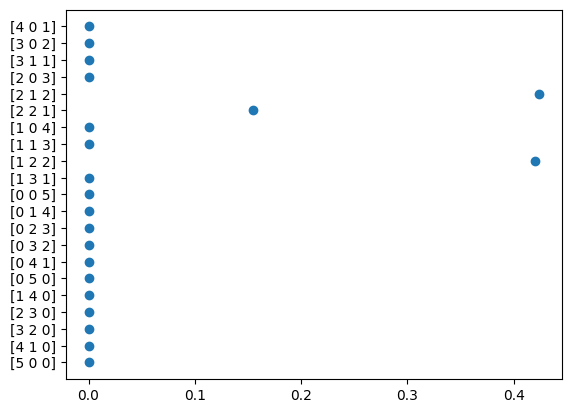

In [195]:
# Strategy against suboptimal agent that is equally likely to pick any action

strategy_sum = train(10000)
normalize(strategy_sum)

plt.plot(normalize(strategy_sum), [np.array_str(strat) for strat in pure_strategies], marker='o', linestyle='')

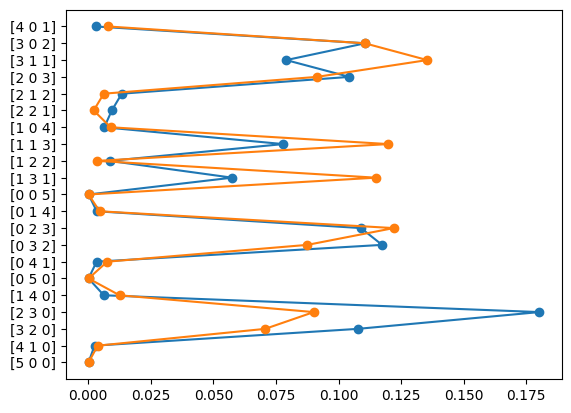

In [186]:
s1, s2 = train2p(100, 1000)
plt.plot(normalize(s1), [np.array_str(strat) for strat in pure_strategies], marker='o')
plt.plot(normalize(s2), [np.array_str(strat) for strat in pure_strategies], marker='o')

Mean score: 1.11 Median score: 1.0


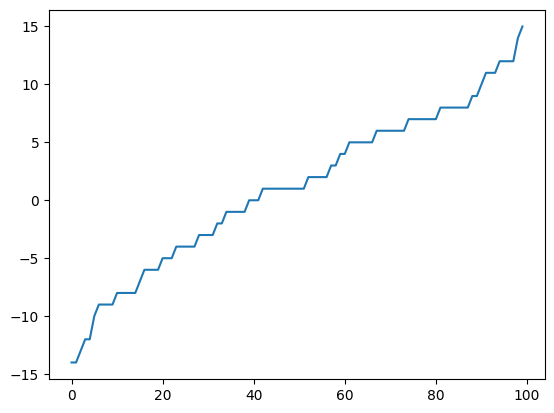

In [193]:
# Evaluating against other selfplaying agent

games = []

for j in range(100):
    game_scores = 0
    for i in range(100):
        action_index = get_action_index(s1)
        opponent_action_index = get_action_index(s2)
        game_scores += get_utilities(opponent_action_index)[action_index]
    games.append(game_scores)

plt.plot(sorted(games))
print("Mean score:", np.mean(games), "Median score:", np.median(games))

Mean score: 28.39 Median score: 28.0


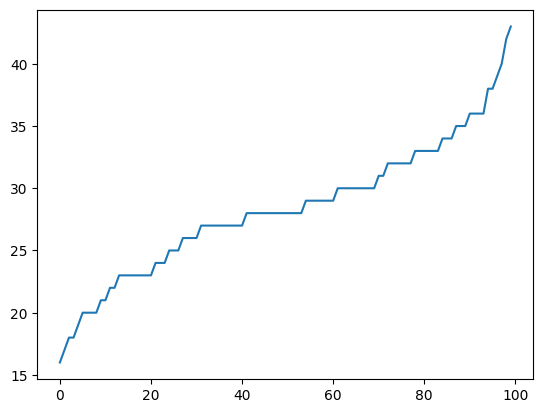

In [192]:
# Evaluating against suboptimal strategy

games = []
opponent_strategy = np.ones(STRATEGY_COUNT) / STRATEGY_COUNT

for j in range(100):
    game_scores = 0
    for i in range(100):
        action_index = get_action_index(strategy_sum)
        opponent_action_index = get_action_index(opponent_strategy)
        game_scores += get_utilities(opponent_action_index)[action_index]
    games.append(game_scores)

plt.plot(sorted(games))
print("Mean score:", np.mean(games), "Median score:", np.median(games))